In [18]:
from collections import Counter
import numpy as np
import scipy.io, random, csv
from scipy import stats
import pandas as pd
import multiprocessing as mp
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [19]:
# General helper funcs

# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission.csv', index_label='Id')
    
# partition dataset into training and validation set based on their indices
def sample(data, label, numSamples):
    totalIndices = np.arange(len(data))
    np.random.shuffle(totalIndices)
    validIndices, trainIndices = totalIndices[:numSamples], totalIndices[numSamples:]
    valid_data = data[validIndices]
    valid_label = label[validIndices]
    train_data = data[trainIndices]
    train_label = label[trainIndices]
    return valid_data, valid_label, train_data, train_label

seed = 266
np.random.seed(seed)

In [20]:
# Load in data

def loadData(dataset):
    if dataset == "titanic":
        # Load titanic data       
        class_names = ["Died", "Survived"]

        # Preprocess data
#         path_train = 'datasets/titanic/titanic_training.csv'
#         data = pd.read_csv(path_train)
#         path_test = 'datasets/titanic/titanic_testing_data.csv'
#         test_data = pd.read_csv(path_test)

#         X, y, features = preprocessTitanic(data)
#         Z, _, f2 = preprocessTitanic(test_data)

        # Read in preprocessed data
        path_train = 'datasets/titanic/titanic_training_processed.csv'
        path_test = 'datasets/titanic/titanic_test_processed.csv'

        train_data = pd.read_csv(path_train)
        features = train_data.columns.values
        y = train_data['survived'].values
        train_data.drop(['survived'], axis=1, inplace=True)
        X = train_data.values
        
        test_data = pd.read_csv(path_test)
        Z = test_data.values
        f2 = test_data.columns.values

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'datasets/spam-dataset/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data'] #5172 entries
        y = np.squeeze(data['training_labels'])
        Z = data['test_data'] #5857 entries
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)
        
    return X, y, Z, features, class_names

In [21]:
# Helper functions for preprocessing Titanic data

# Fill in NaN with constant
def fillInWithConstant(val, constant, firstLetter=False):
    if val != val: #nan
        return constant
    if firstLetter:
        return val[0]
    else:
        return val

# Group tickets into categories
def getTicketGroup(ticket):
    if ticket != ticket:
        return ticket
    
    ticketGroups = {
        "A4": ["A/4", "A4.", "A. 2."],
        "A5": ["A./5.", "A./5", "A/5", "A/5.", "A/S", "A.5", "AQ"],
        "CA" : ["C.A", "CA", "C "],
        "FC": ["F.C.", "Fa"],
        "PC": ["PC"],
        "PP": ["PP"],
        "SC": ["S.C.", "SC/", "SCO"],
        "SO": ["S.O.", "SO/"],
        "SOTON": ["SOTON", "STON"],
        "WC": ["W./C.", "W/C"],
        "WE": ["W.E.P", "WE/P"]
    }
    for group in ticketGroups.keys():
        for name in ticketGroups[group]:
            if name in ticket:
                return group
    
    if len(ticket) > 7: #letter&number
        print(ticket)
        ticketParts = ticket.split(" ")
        ticket = ticketParts[len(ticketParts)-1]
        if len(ticket) < 4:
            print('todo')
    elif len(ticket) == 7:
        return "SOTON"
    elif len(ticket) == 6:
        return ticket[0] + "xxxxx"
    elif len(ticket) == 5 and ticket[0] == '1' and ticket[1] <= '3': 
        return "FC"
    elif len(ticket) == 5 and ticket[0] == '1' and ticket[1] > '3': 
        return "PC"
    elif len(ticket) == 4 and ticket[0] == '2': 
        return "SC"
    elif len(ticket) == 4 and ticket[0] == '6': 
        return "WC"
    elif len(ticket) == 4 and ticket[0] == '6': 
        return "WE"
    elif len(ticket) == 4:
        return "A5"
    elif len(ticket) == 5:
        return "CA"
    return "etc"

In [22]:
# Preprocess Titanic data to fill in NaN and to group categorical data
def preprocessTitanic(dataframe):
    # drop row w all nan
    dataframe.dropna(how='all', inplace=True)

    if "survived" in dataframe.columns:
        labels = dataframe["survived"].values #numpy array
        dataframe.drop(['survived'], axis=1, inplace=True)
    else:
        labels = []

    pclass1Age = stats.mode(dataframe[dataframe['pclass']==1]['age'])[0][0]
    pclass2Age = np.mean(dataframe[dataframe['pclass']==2]['age'])
    pclass3Age = stats.mode(dataframe[dataframe['pclass']==3]['age'])[0][0]
    pclassAges = [pclass1Age, pclass2Age, pclass3Age]

    pclass1Fare = np.mean(dataframe[dataframe['pclass']==1]['fare'])
    pclass2Fare = np.mean(dataframe[dataframe['pclass']==2]['fare'])
    pclass3Fare = stats.mode(dataframe[dataframe['pclass']==3]['fare'])[0][0]
    pclassFares = [pclass1Fare, pclass2Fare, pclass3Fare]

    pclassCabins = ["C", "D", "E"]

    for i in range(1, 4):
        app = dataframe[dataframe['pclass']==i]['age'].apply(fillInWithConstant, constant=pclassAges[i-1])
        dataframe.loc[np.array(app.index), 'age'] = app.values
        app = dataframe[dataframe['pclass']==i]['fare'].apply(fillInWithConstant, constant=pclassFares[i-1])
        dataframe.loc[np.array(app.index), 'fare'] = app.values
        app = dataframe[dataframe['pclass']==i]['cabin'].apply(fillInWithConstant, constant=pclassCabins[i-1], firstLetter=True)
        dataframe.loc[np.array(app.index), 'cabin'] = app.values

    dataframe['ticket'] = dataframe['ticket'].apply(getTicketGroup)

    for p in np.unique(dataframe['ticket']):
        if p != "FC" and p != "SC":
            cons = "S"
        else:
            cons = "C"
        app = dataframe[dataframe['ticket']==p]['embarked'].apply(fillInWithConstant, constant=cons)
        dataframe.loc[np.array(app.index), 'embarked'] = app.values

    categorical_cols = ['pclass', 'sex', 'embarked', 'ticket', 'cabin']
    numerical_cols = [col for col in dataframe.columns.values if col not in categorical_cols]

    dataframe['pclass'] = dataframe['pclass'].astype(str)
    
    # Map categories to binary variables
    records = dataframe[categorical_cols].to_dict(orient='records')
    vect = DictVectorizer(sparse=False)
    featureVects = vect.fit_transform(records)
    colnames = vect.get_feature_names() #get name of cols

    features = pd.DataFrame(dataframe[numerical_cols])
    for i in range(len(colnames)):
        features[colnames[i]] = featureVects[:, i]
    
    # Export preprocessed data 
#     features['survived'] = labels
#     features.to_csv("./titanic_training_processed.csv", index=True, index_label="pclass")

    return features.values, labels, features.columns.values

In [23]:
class Node:
    def __init__(self, splitRule, curDepth=0, label=None):
        self.curDepth = curDepth
        self.splitRule = splitRule
        self.label = label #if leaf
        self.left = None
        self.right = None
    def setLabel(self, label):
        self.label = label
    def __repr__(self):
        return str(self.__dict__)

In [24]:
class DecisionTree:

    def __init__(self, maxDepth, mPercent=1, debug=False):
        self.root = None
        self.maxDepth = maxDepth
        self.numFeatures = -1
        self.mPercent = mPercent
        self.predictions = None
        self.test_data = None
        self.debug=debug
        
    @staticmethod
    def printTree(node, depth):
        if node is None:
            return ""
        if node.splitRule is not None:
            featureIdx, thresh = node.splitRule[0], node.splitRule[1]
            ret = "\t"*depth + "Split feature: {} ({}), Split threshold: {} \n".format(features[featureIdx], featureIdx, thresh)
        else:
            ret = "\t"*depth + "Leaf label: {} ({}) \n".format(class_names[node.label], node.label)
        ret += DecisionTree.printTree(node.left, depth+1)
        ret += DecisionTree.printTree(node.right, depth+1)
        return ret

    def __repr__(self):
        ret = DecisionTree.printTree(self.root, 0)
        return ret
    
    # takes in labels of data stored @ node & compute entropy for the distribution of the labels (y)
    @staticmethod
    def entropy(labels):
        unique_labels = np.unique(labels)
        numLabels = len(labels)
        label_portion = [np.count_nonzero(labels == label)/numLabels+10**(-6) for label in unique_labels]
        return -1*sum([p*np.log(p) for p in label_portion])

    #calculates information gain given a vector of features (X), labels (y) and a split threshold
    @staticmethod
    def information_gain(features, labels, threshold):
        hS = DecisionTree.entropy(labels)
        hAfter = DecisionTree.entropy_hAfter(features, labels, threshold)
        return hS - hAfter
    
    @staticmethod
    def entropy_hAfter(features, labels, threshold):
        sL, sR = labels[np.where(features<=threshold)[0]], labels[np.where(features>threshold)[0]]

        lenSL, lenSR = len(sL), len(sR)
        hAfter = (lenSL*DecisionTree.entropy(sL) + lenSR*DecisionTree.entropy(sR))/(lenSL+lenSR)
        return hAfter

    #calculates the gini impurity given all the labels (y)
    @staticmethod
    def gini_impurity(labels):
        unique_labels = np.unique(labels)
        numLabels = len(labels)
        label_portion = [np.count_nonzero(labels == label)/numLabels for label in unique_labels]
        return sum([p*(1-p) for p in label_portion])

    # calculates reduction in impurity gain given a vector of features and a split threshold
    @staticmethod
    def gini_purification(features, labels, threshold):
        hS = DecisionTree.gini_impurity(labels)
        hAfter = DecisionTree.gini_hAfter(features, labels, threshold)
        return hS - hAfter
    
    @staticmethod
    def gini_hAfter(features, labels, threshold):
        sL, sR = labels[np.where(features<=threshold)[0]], labels[np.where(features>threshold)[0]]
        lenSL, lenSR = len(sL), len(sR)
        hAfter = (lenSL*DecisionTree.gini_impurity(sL) + lenSR*DecisionTree.gini_impurity(sR))/(lenSL+lenSR)
        return hAfter
        
    #return a split of the dataset given an index of the feature and a threshold for it
    @staticmethod
    def split(features, labels, idx, thresh):
        sLData = features[np.where(features[:, idx]<=thresh)[0]]
        sLLabels = labels[np.where(features[:, idx]<=thresh)[0]]
        sRData = features[np.where(features[:, idx]>thresh)[0]]
        sRLabels = labels[np.where(features[:, idx]>thresh)[0]]
        return (sLData, sLLabels), (sRData, sRLabels)
    
    def segmenter(self, data, labels):
        if len(data) < 2 or len(labels) < 2 or len(set(labels)) == 1:
            return None

        bestGini, bestInfoGain = np.inf, np.inf
        bestFeature, bestThreshold = -1, 0
        threshMin, threshMax = 0, 0
        
        possibleFeatures = self.sampleFeatures()
        for i in possibleFeatures:
            features = data[:, i] #ith col/feature
            feature_mode = Counter(features).most_common(1)[0][0]
            
            threshR = feature_mode + .5
            childGini = DecisionTree.gini_hAfter(features, labels, threshR)
            if childGini < bestGini:
                bestFeature, bestGini, bestThreshold = i, childGini, threshR
                threshMin, threshMax = threshR, max(features)

        features = data[:, bestFeature]
        #thresholds = np.linspace(threshMin, threshMax, num=8)
        thresholds = np.linspace(min(features), max(features), num=20)
        for thresh in thresholds:
            childGini = DecisionTree.gini_hAfter(features, labels, thresh)
            
            if childGini < bestGini:
                bestThreshold, bestGini = thresh, childGini
                
        return [bestFeature, bestThreshold]
    
    def sampleFeatures(self):
        if self.mPercent == 1:
            return self.allFeatures
        return np.random.choice(self.allFeatures, int(self.mPercent * self.numFeatures), replace=False)
        #return np.random.choice(self.allFeatures, int(self.numFeatures**.5), replace=False)
    
    # fit the model to a training set.
    def fit(self, data, labels):
        if len(data) < 1 or len(labels) < 1:
            return None

        if self.numFeatures == -1:
            self.numFeatures = len(data[0])
            self.allFeatures = np.arange(self.numFeatures)
        return self.fitHelper(data, labels, 0)

    def fitHelper(self, data, labels, curDepth):
        lenData = len(data)
        if lenData < 1:
            return None

        stopFlag = False
        most_common = Counter(labels).most_common(1)[0]
        
        if most_common[1] == lenData or most_common[1]/lenData >= 0.95:
            if self.debug:
                print(len(data), 'end bc have clear label') 
            stopFlag = True
        if curDepth >= self.maxDepth or lenData < 10:
            if self.debug:
                print(len(data), 'end bc reached maxdepth') 
            stopFlag = True
        
        if not stopFlag:
            thisNode = Node(splitRule=self.segmenter(data, labels), curDepth = curDepth)
            
            if thisNode.splitRule is not None:
                    (sLData, sLLabels), (sRData, sRLabels) = DecisionTree.split(data, labels, thisNode.splitRule[0], thisNode.splitRule[1])
                    if self.debug:
                        print(len(data), len(sLData), len(sRData))
                    if len(sLData) < 5 or len(sRData) < 5:
                        if self.debug:
                            print(len(data), 'end bc next split too small') 
                        stopFlag = True
                    else:
                        if self.root is None:
                            self.root = thisNode
                        thisNode.left = self.fitHelper(sLData, sLLabels, curDepth + 1)
                        thisNode.right = self.fitHelper(sRData, sRLabels, curDepth + 1)
            else:
                if self.debug:
                    print(len(data), 'end bc no splitRule') 
                stopFlag = True
                
        if stopFlag:
            if self.debug:
                print('turning into a leaf', len(data))
            thisNode = Node(splitRule=None, curDepth = curDepth)
            if self.root is None:
                self.root = thisNode
            thisNode.setLabel(int(most_common[0]))
        return thisNode

    #predict the labels for input data (X) 
    def predict(self, data):
        self.predictions = np.full(len(data), -1)
        self.test_data = data
        self.predictHelper(self.root, np.arange(len(data)))
        return self.predictions
        
    # return list of labels given data
    def predictHelper(self, curNode, indices):
        if curNode is None:
            return  
        if curNode.label is not None:
            self.predictions[indices] = curNode.label
        else:
            featureIdx, thresh = curNode.splitRule[0], curNode.splitRule[1]
            indicesL, indicesR = indices[np.where(self.test_data[indices][:, featureIdx]<=thresh)[0]], indices[np.where(self.test_data[indices][:, featureIdx]>thresh)[0]]
            self.predictHelper(curNode.left, indicesL)
            self.predictHelper(curNode.right, indicesR)
            

In [42]:
class RandomForest():
    def __init__(self, numTrees=10, maxDepth=5, samplePercent=.8, mPercent=.5):
        self.numTrees = numTrees
        self.maxDepth = maxDepth
        self.samplePercent = samplePercent
        self.mPercent = mPercent
        self.trees = None

    # return indices selected randomly with replacement
    def bagging(self, dataIndices):
        return np.random.choice(dataIndices, int(self.samplePercent*len(dataIndices)), replace=True)

    # fit the model to a training set.
    def fit(self, X, y):
        dataIndices = np.arange(len(X))
        results = []
        for i in range(self.numTrees):
            idx = self.bagging(dataIndices)
            data, label = X[idx], y[idx]
            tree = DecisionTree(self.maxDepth, self.mPercent)
            tree.fit(data, label)
            results.append(tree)
        self.trees = results
        
    #multiprocessing ver
#     def fit(self, X, y): 
#         dataIndices = np.arange(len(X))
#         treeBagIdx = [self.bagging(dataIndices) for i in range(self.numTrees)]
        
#         trees = mp.Queue()
#         processes = [mp.Process(target=self.fitTree, args=(X, y, treeBagIdx[i], trees)) for i in range(self.numTrees)]
#         for p in processes:
#             p.start()
#         for p in processes:
#             p.join()
#         results = [trees.get() for p in processes]
#         self.trees = results
#     def fitTree(self, X, y, bagIdx, trees):
#         data, label = X[bagIdx], y[bagIdx]
#         tree = DecisionTree(self.maxDepth, self.mPercent)
#         tree.fit(data, label)
#         trees.put(tree)
    
    # predict the labels for input data 
    def predict(self, X):
        allPreds = [tree.predict(X) for tree in self.trees]
        predictions = scipy.stats.mode(allPreds)[0][0]
        return predictions, allPreds

### Test out my code below

In [52]:
# Load data

dataset = "titanic"
#dataset = "spam"

X, y, Z, features, class_names = loadData(dataset)

In [55]:
# 2.4 DecisionTree: Training & Validation accuracies

valid_data, valid_label, train_data, train_label = sample(X, y, int(0.2*len(X))) #20/80 valid/train

m = 1
maxDepth = 10
classifier = DecisionTree(maxDepth, m)
classifier.fit(train_data, train_label)
valid_pred = classifier.predict(valid_data)
valid_score = accuracy_score(valid_label, valid_pred)
train_pred = classifier.predict(train_data)
train_score = accuracy_score(train_label, train_pred)
print(valid_score, train_score)

0.7638190954773869 0.8322903629536921


In [56]:
# 2.4 RandomForest: Training & Validation accuracies
numTrees = 10
maxDepth = 10
samplePercent = 0.9
mPercent = 1
forest = RandomForest(numTrees, maxDepth, samplePercent, mPercent)
forest.fit(train_data, train_label)
valid_pred, _ = forest.predict(valid_data)
valid_score = round(accuracy_score(valid_label, valid_pred), 3)
train_pred, _ = forest.predict(train_data)
train_score = round(accuracy_score(train_label, train_pred), 3)
print(valid_score, train_score)

0.809 0.827


1 0.7678916827852998
2 0.7843326885880078
3 0.7978723404255319
4 0.8007736943907157
5 0.8056092843326886
6 0.8152804642166345
7 0.8172147001934236
8 0.8172147001934236
9 0.8230174081237911
10 0.8230174081237911
11 0.8249516441005803
12 0.8249516441005803
13 0.8249516441005803
14 0.8191489361702128
15 0.8191489361702128
16 0.8191489361702128
17 0.8191489361702128
18 0.8191489361702128
19 0.8191489361702128
20 0.8191489361702128
21 0.8191489361702128
22 0.8191489361702128
23 0.8191489361702128
24 0.8191489361702128
25 0.8191489361702128
26 0.8191489361702128
27 0.8191489361702128
28 0.8191489361702128
29 0.8191489361702128
30 0.8191489361702128
31 0.8191489361702128
32 0.8191489361702128
33 0.8191489361702128
34 0.8191489361702128
35 0.8191489361702128
36 0.8191489361702128
37 0.8191489361702128
38 0.8191489361702128
39 0.8191489361702128
40 0.8191489361702128


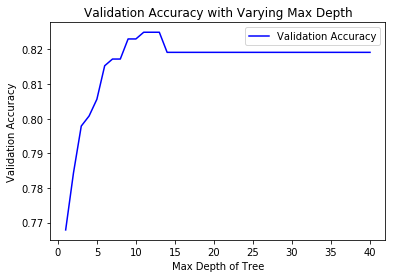

In [26]:
# 2.5.3 DecisionTree on Spam: Validation Accuracy with Varying Max Depth

valid_data, valid_label, train_data, train_label = sample(X, y, int(0.2*len(X))) #20/80 valid/train

m = 1
depths = np.arange(1, 41)
validation_accuracies = []
for depth in depths:
    maxDepth = depth
    classifier = DecisionTree(maxDepth, m)
    classifier.fit(train_data, train_label)
    valid_pred = classifier.predict(valid_data)
    score = accuracy_score(valid_label, valid_pred)
    print(depth, score)
    validation_accuracies.append(score)
    
#     skTree = tree.DecisionTreeClassifier(max_depth=depth)
#     skTree.fit(train_data, train_label)
#     skvalid_pred = skTree.predict(valid_data)
#     score = accuracy_score(valid_label, skvalid_pred)
#     print(score)
#     dot_data = StringIO()
#     export_graphviz(skTree, out_file=dot_data,  
#                     filled=True, rounded=True,
#                     special_characters=True)
#     graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#     Image(graph.create_png())
#     graph.write_pdf("tree"+str(depth)+".pdf")

plt.plot(depths, validation_accuracies, color='blue', label='Validation Accuracy')
plt.xticks()
plt.xlabel("Max Depth of Tree")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy with Varying Max Depth")
plt.legend()
plt.savefig("VaryingDepth.jpg")
plt.show()

In [67]:
#2.6
maxDepth = 3
m=1
classifier = DecisionTree(maxDepth, m)
classifier.fit(X, y)
print(classifier)
# skTree = tree.DecisionTreeClassifier(max_depth=maxDepth)
# skTree.fit(X, y)
# dot_data = StringIO()
# export_graphviz(skTree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())
# graph.write_pdf("tree"+str(depth)+".pdf")

Split feature: sex=female (19), Split threshold: 0.5 
	Split feature: pclass=1.0 (16), Split threshold: 0.5 
		Split feature: parch (3), Split threshold: 0.5 
			Leaf label: Died (0) 
			Leaf label: Died (0) 
		Leaf label: Died (0) 
	Split feature: pclass=3.0 (18), Split threshold: 0.5 
		Split feature: fare (4), Split threshold: 26.5 
			Leaf label: Survived (1) 
			Leaf label: Survived (1) 
		Split feature: ticket=A5 (25), Split threshold: 0.5 
			Leaf label: Survived (1) 
			Leaf label: Died (0) 



True

In [48]:
# Kaggle: hyperparameter tuning
valid_data, valid_label, train_data, train_label = sample(X, y, int(0.2*len(X))) #20/80 valid/train

nTrees = np.arange(1, 21)#np.arange(3, 103, 10)
percents = np.linspace(0.1,1, 10)

# for d in np.arange(1, 20):
for p in percents:
# for n in nTrees:
    numTrees = 10
    maxDepth = 17
    samplePercent = .8
    mPercent = p
    forest = RandomForest(numTrees, maxDepth, samplePercent, mPercent)
    forest.fit(train_data, train_label)
    valid_pred, allPreds = forest.predict(valid_data)
    vscore = round(accuracy_score(valid_label, valid_pred), 3)
    train_pred, _ = forest.predict(train_data)
    tscore = round(accuracy_score(train_label, train_pred), 3)
    print(p, vscore, tscore)

0.1 0.811 0.817
0.2 0.835 0.823
0.30000000000000004 0.836 0.826
0.4 0.828 0.829
0.5 0.832 0.832
0.6 0.833 0.83
0.7000000000000001 0.838 0.833
0.8 0.831 0.83
0.9 0.834 0.827
1.0 0.831 0.83
